In [2]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
%matplotlib inline
plt.style.use('seaborn')

C:\Users\kot\AppData\Local\Temp\ipykernel_26904\1094269666.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [38]:
data = pd.read_csv('data/insurance.csv')
display(data.head())
print(data.shape)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


(1338, 7)


Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:

In [6]:
display(data.isnull().sum())
display(data.dtypes)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
#Создаем копию данных для облегчения работы с изменениями в таблице
temp_data = data.copy()

In [8]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = temp_data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

In [23]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = temp_data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['sex', 'smoker', 'region']



Прежде чем приступать к этапу подготовки данных для модели, вы можете произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

        гистограммы/коробчатые диаграммы числовых признаков;
        столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;
        диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).



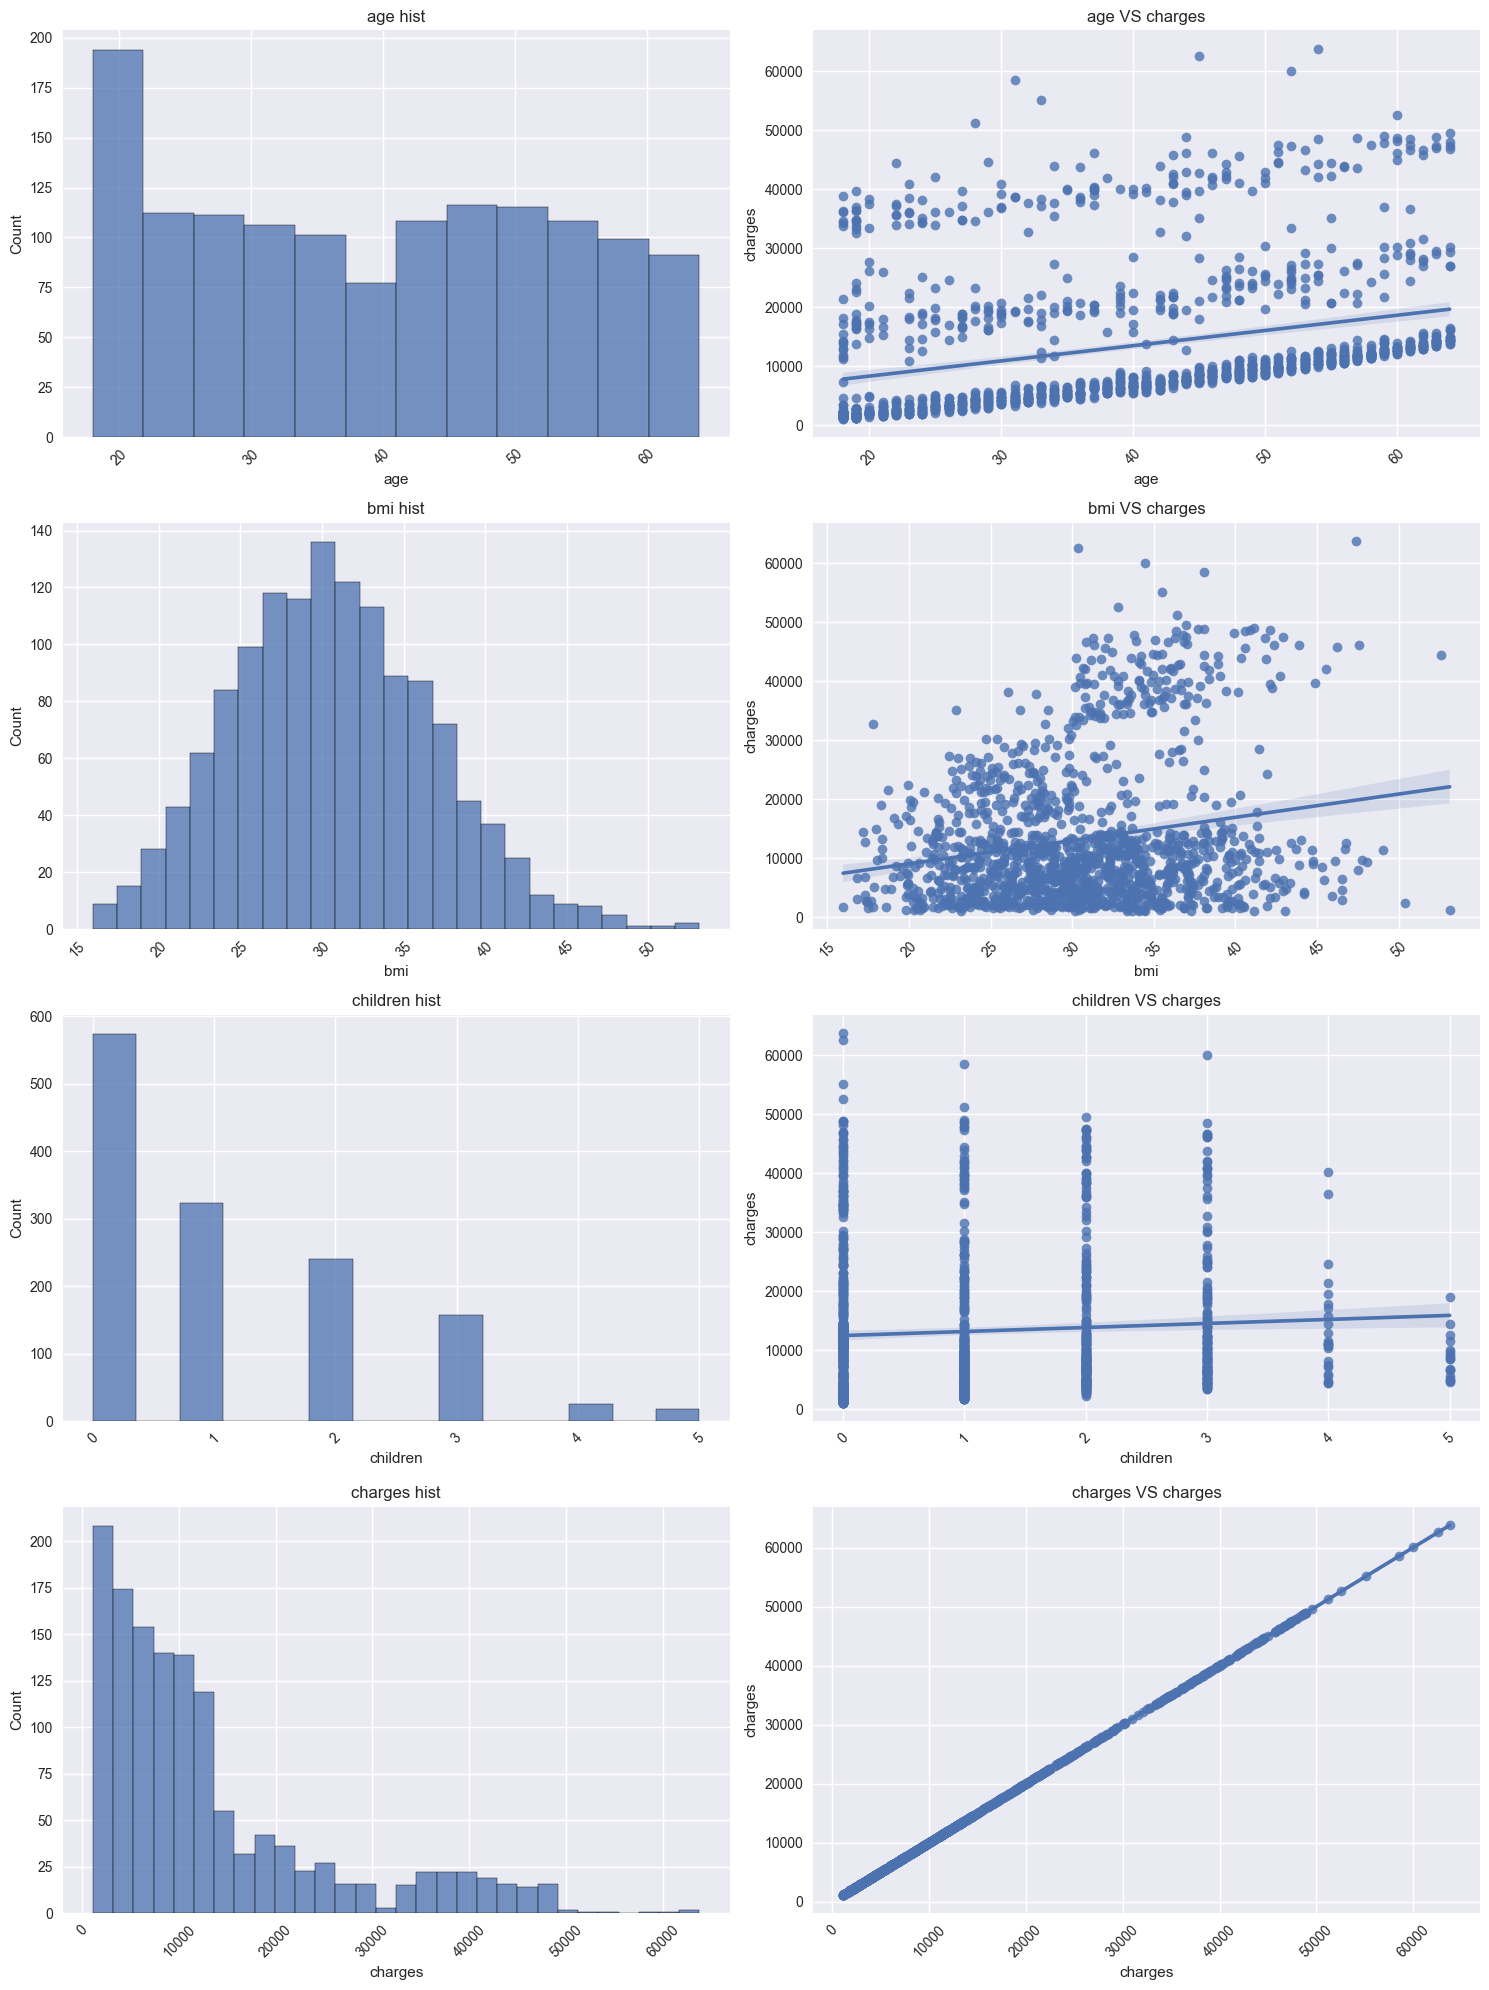

In [10]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей

#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков


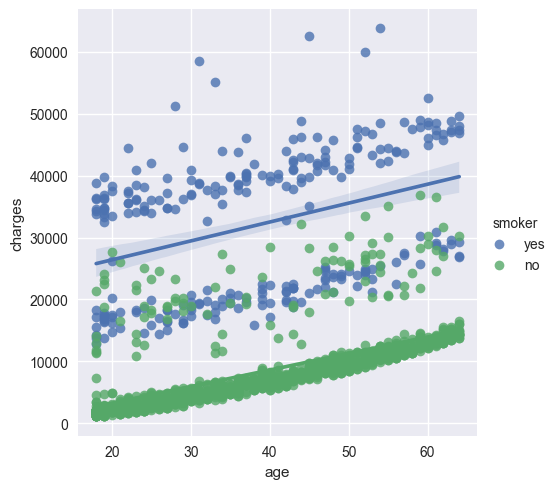

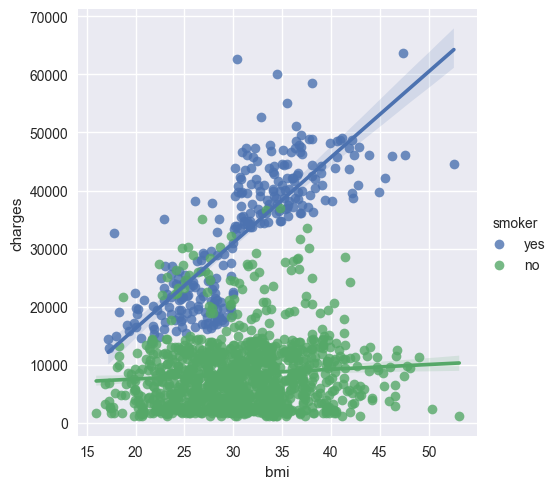

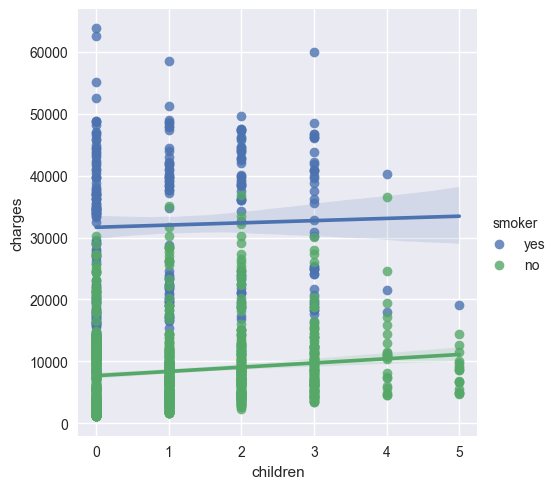

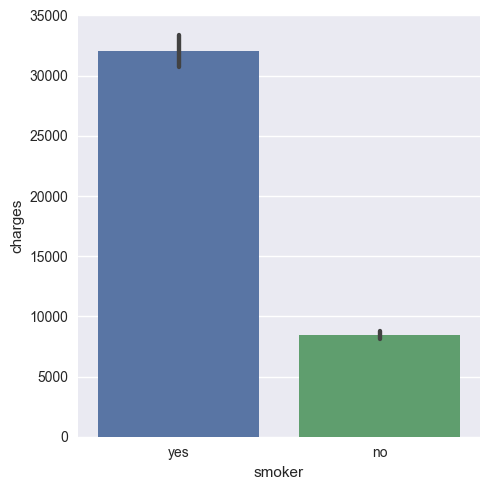

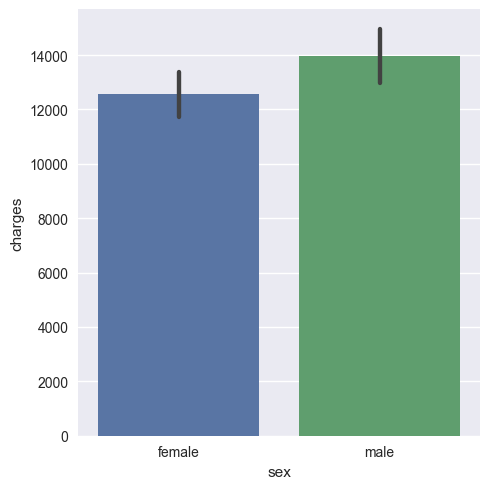

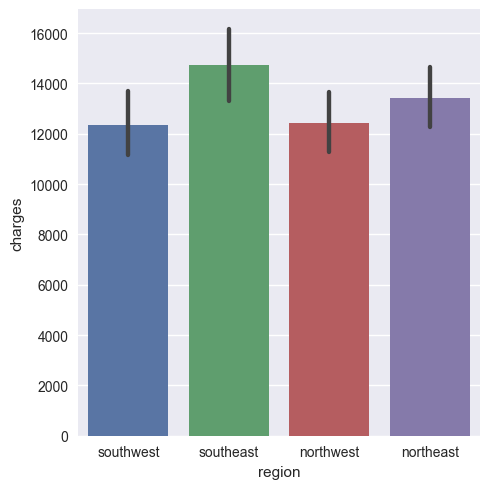

In [34]:
regplot = sns.lmplot(data=temp_data, x='age', y='charges', hue='smoker')
regplot = sns.lmplot(data=temp_data, x='bmi', y='charges', hue='smoker')
regplot = sns.lmplot(data=temp_data, x='children', y='charges', hue='smoker')

sns.catplot(data=temp_data, x='smoker', y='charges', kind="bar")
sns.catplot(data=temp_data, x='sex', y='charges', kind="bar")
sns.catplot(data=temp_data, x='region', y='charges', kind="bar")



C:\Users\kot\AppData\Local\Temp\ipykernel_26904\282801187.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(temp_data.corr(), annot=True);


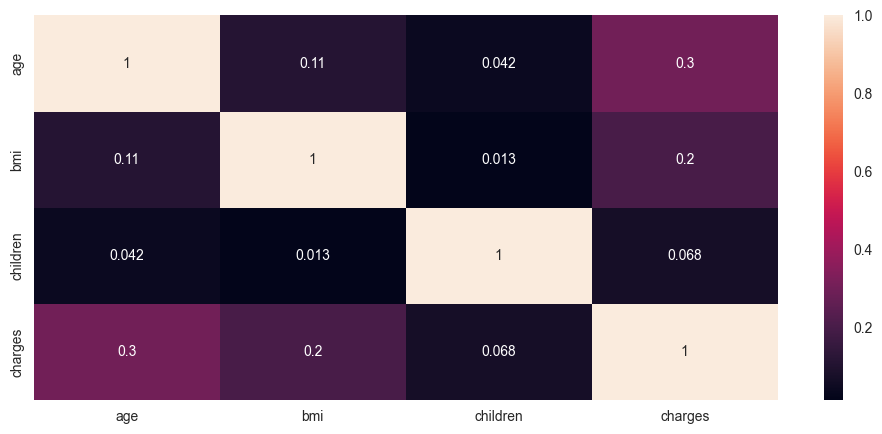

In [11]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(temp_data.corr(), annot=True);

In [39]:
#кодируем бинарные категориальные признаки
temp_data['smoker'] = temp_data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
temp_data['sex'] = temp_data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
temp_data = pd.get_dummies(temp_data)
temp_data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [43]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

Выделим факторы и целевой признак в отдельные таблицы:

 Задание 6.1
1/1 point (graded)

Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией train_test_split.

В качестве значения параметра random_state укажите число 42.

In [44]:
features = temp_data.drop('charges', axis=1).columns
X, y = temp_data[features], data['charges']

In [46]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


 Задание 6.2
1 point possible (graded)

Обучите модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных. Все параметры оставьте по умолчанию.

In [51]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)


In [52]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
#Выводим coef
print('w0: {}'.format(lr.intercept_)) #свободный член w0
print('w1: {}'.format(lr.coef_)) #остальные параметры модели w1, w2, ..., wm

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888
w0: -12390.804294570278
w1: [ 2.56975706e+02 -1.85916916e+01  3.37092552e+02  4.25278784e+02
  2.36511289e+04  4.59585244e+02  8.89079180e+01 -1.98279052e+02
 -3.50214110e+02]


 Задание 6.4
1 point possible (graded)

Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием: (без модуля).

#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_lstat = y - lr_lstat.predict(boston_data[['LSTAT']])
#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


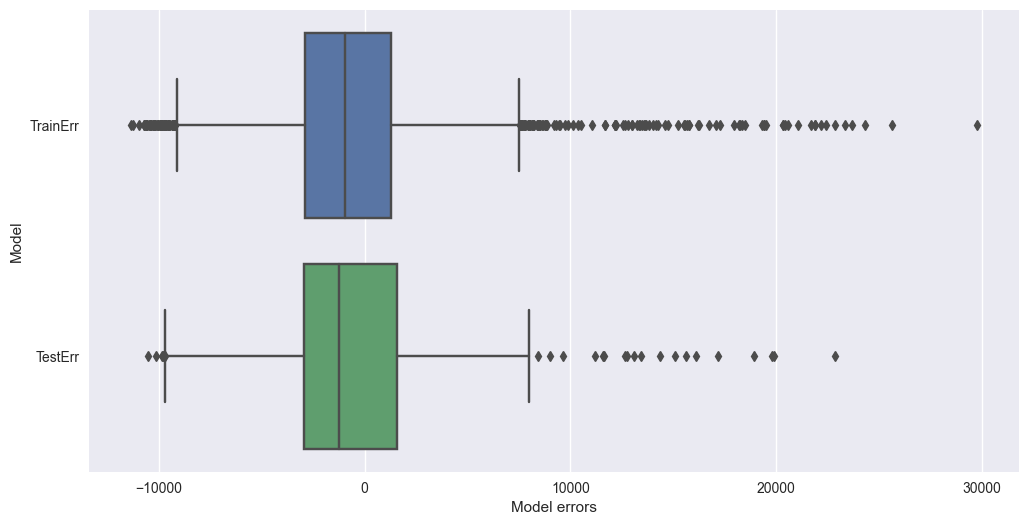

In [58]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
y_errors_lr_train = y_train - y_train_pred
y_errors_lr_test = y_test - y_test_pred
#
errors_df = pd.DataFrame(
    {'TrainErr' : y_errors_lr_train,
    'TestErr' : y_errors_lr_test
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат


 Задание 6.5
1 point possible (graded)

Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Расчёт параметров нормализации (fit) произведите на тренировочной выборке.

In [67]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)
print(X_train_scale.shape)

#Инициализируем объект класса poly регрессия
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Обучаем модель - ищем параметры
poly.fit(X_train_scale)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scale)
X_test_scaled_poly = poly.transform(X_test_scale)

print(X_train_scaled_poly.shape)




(1070, 9)
(1070, 54)


In [68]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train_scaled_poly)
y_test_pred = lr.predict(X_test_scaled_poly)

In [69]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
#Выводим coef
print('w0: {}'.format(lr.intercept_)) #свободный член w0
print('w1: {}'.format(lr.coef_)) #остальные параметры модели w1, w2, ..., wm

Train R^2: 0.842
Train MAE: 2912.014
Train MAPE: 29.398


Test R^2: 0.866
Test MAE: 2755.768
Train MAPE: 30.333
w0: 1.715068454483469e+16
w1: [-3.06227002e+16  1.86235653e+17  5.08892343e+14  4.78013503e+15
  1.28211003e+16 -1.41917221e+16 -6.61624882e+15 -6.95752237e+15
 -4.20906736e+15  8.42000000e+03  8.26000000e+02  9.40000000e+02
 -1.67400000e+03  1.20000000e+02  3.06227002e+16  3.06227002e+16
  3.06227002e+16  3.06227002e+16 -1.53014624e+17  7.13750000e+02
 -1.22287500e+03  2.17125000e+02 -3.32210291e+16 -3.32210291e+16
 -3.32210291e+16 -3.32210291e+16 -9.68037500e+03  1.60443750e+03
  5.48209531e+04 -5.08892343e+14 -5.08892343e+14 -5.08892343e+14
 -5.08892343e+14 -2.04800000e+03 -2.23400000e+03 -4.78013503e+15
 -4.78013503e+15 -4.78013503e+15 -4.78013503e+15 -6.39877451e+15
 -6.42232583e+15 -6.42232583e+15 -6.42232583e+15 -6.42232583e+15
 -2.95896241e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.05344357e+16  0.00000000e+00  0.00000000e+00 -1.01931622e+16
  0.00000000e

 Задание 6.8
3 points possible (graded)

Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

Чему равны метрики , и на тестовой выборке?

Значение округлите до трёх знаков после запятой, а значения и до целого числа.

In [70]:
#Инициализируем объект класса линейная регрессия с L1-регуляризацией 
ridge_lr_poly = linear_model.Lasso(alpha=1, max_iter=2000)
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred = ridge_lr_poly.predict(X_test_scaled_poly)

In [71]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
#Выводим coef
print('w0: {}'.format(lr.intercept_)) #свободный член w0
print('w1: {}'.format(lr.coef_)) #остальные параметры модели w1, w2, ..., wm

Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070
w0: 1.715068454483469e+16
w1: [-3.06227002e+16  1.86235653e+17  5.08892343e+14  4.78013503e+15
  1.28211003e+16 -1.41917221e+16 -6.61624882e+15 -6.95752237e+15
 -4.20906736e+15  8.42000000e+03  8.26000000e+02  9.40000000e+02
 -1.67400000e+03  1.20000000e+02  3.06227002e+16  3.06227002e+16
  3.06227002e+16  3.06227002e+16 -1.53014624e+17  7.13750000e+02
 -1.22287500e+03  2.17125000e+02 -3.32210291e+16 -3.32210291e+16
 -3.32210291e+16 -3.32210291e+16 -9.68037500e+03  1.60443750e+03
  5.48209531e+04 -5.08892343e+14 -5.08892343e+14 -5.08892343e+14
 -5.08892343e+14 -2.04800000e+03 -2.23400000e+03 -4.78013503e+15
 -4.78013503e+15 -4.78013503e+15 -4.78013503e+15 -6.39877451e+15
 -6.42232583e+15 -6.42232583e+15 -6.42232583e+15 -6.42232583e+15
 -2.95896241e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.05344357e+16  0.00000000e+00  0.00000000e+00 -1.01931622e+16
  0.00000000e

 Задание 6.9
3 points possible (graded)

Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.

Чему равны метрики , и на тестовой выборке?

Значение округлите до трёх знаков после запятой, а значения и до целого числа.

In [73]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge(alpha=1, max_iter=2000)
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred = ridge_lr_poly.predict(X_test_scaled_poly)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
#Выводим coef
print('w0: {}'.format(lr.intercept_)) #свободный член w0
print('w1: {}'.format(lr.coef_)) #остальные параметры модели w1, w2, ..., wm

Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380
w0: 1.715068454483469e+16
w1: [-3.06227002e+16  1.86235653e+17  5.08892343e+14  4.78013503e+15
  1.28211003e+16 -1.41917221e+16 -6.61624882e+15 -6.95752237e+15
 -4.20906736e+15  8.42000000e+03  8.26000000e+02  9.40000000e+02
 -1.67400000e+03  1.20000000e+02  3.06227002e+16  3.06227002e+16
  3.06227002e+16  3.06227002e+16 -1.53014624e+17  7.13750000e+02
 -1.22287500e+03  2.17125000e+02 -3.32210291e+16 -3.32210291e+16
 -3.32210291e+16 -3.32210291e+16 -9.68037500e+03  1.60443750e+03
  5.48209531e+04 -5.08892343e+14 -5.08892343e+14 -5.08892343e+14
 -5.08892343e+14 -2.04800000e+03 -2.23400000e+03 -4.78013503e+15
 -4.78013503e+15 -4.78013503e+15 -4.78013503e+15 -6.39877451e+15
 -6.42232583e+15 -6.42232583e+15 -6.42232583e+15 -6.42232583e+15
 -2.95896241e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.05344357e+16  0.00000000e+00  0.00000000e+00 -1.01931622e+16
  0.00000000e

In [96]:
# Initialize data to Dicts of series. 
d = {'f1' : pd.Series([2, 4, 6, 8, 10], index =['e1', 'e2', 'e3', 'e4', 'e5']), 
   'f2' : pd.Series([2, 4, 6, 8, 10], index =['e1', 'e2', 'e3', 'e4', 'e5']),
   'f3' : pd.Series([2, 4, 6, 8, 10], index =['e1', 'e2', 'e3', 'e4', 'e5'])}
 
# creates Dataframe. 
dframe = pd.DataFrame(d) 
display(dframe)

#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(dframe)
#Производим преобразование для каждой из выборок
dframe_scale = scaler.transform(dframe)
display(dframe_scale)


,f1,f2,f3
e1,2,2,2
e2,4,4,4
e3,6,6,6
e4,8,8,8
e5,10,10,10


array([[0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25],
       [0.5 , 0.5 , 0.5 ],
       [0.75, 0.75, 0.75],
       [1.  , 1.  , 1.  ]])

In [95]:
# Initialize data to Dicts of series. 
d = {'f1' : pd.Series([2, 4, 6, 8, 10], index =['e1', 'e2', 'e3', 'e4', 'e5']), 
   'f2' : pd.Series([2, 4, 6, 8, 10], index =['e1', 'e2', 'e3', 'e4', 'e5']),
   'f3' : pd.Series([2, 4, 6, 8, 10], index =['e1', 'e2', 'e3', 'e4', 'e5'])}
 
# creates Dataframe. 
dframe = pd.DataFrame(d) 
display(dframe)


features = dframe.drop('f3', axis=1).columns
X, y = dframe[features], dframe['f3']

#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.4, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
display(X_train)
display(X_test)

#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
dframe_X_train_scale = scaler.transform(X_train)
dframe_X_test_scale = scaler.transform(X_test)
display(dframe_X_train_scale)
display(dframe_X_test_scale)






,f1,f2,f3
e1,2,2,2
e2,4,4,4
e3,6,6,6
e4,8,8,8
e5,10,10,10


,f1,f2
e3,6,6
e1,2,2
e4,8,8


,f1,f2
e2,4,4
e5,10,10


array([[0.66666667, 0.66666667],
       [0.        , 0.        ],
       [1.        , 1.        ]])

array([[0.33333333, 0.33333333],
       [1.33333333, 1.33333333]])